In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import GridSearchCV
from keras import layers,models
from scikeras.wrappers import KerasClassifier
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report 
import pandas as pd
from keras.utils import plot_model
import pydot
import graphviz
import pydotplus
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.utils import to_categorical
import shutil
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score

C:\Users\39324\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_data_path = './Training'
test_data_path = './Testing'

categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

img_size = 64

def create_data(data_path):
    data = []
    labels = []
    error_count = 0  # Counter for failed image loading
    for category in categories:
        path = os.path.join(data_path, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Failed to load image: {os.path.join(path, img)}")
                    error_count += 1
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append(resized_arr)
                labels.append(class_num)
            except Exception as e:
                print(f"Error processing image: {os.path.join(path, img)} - {e}")
                error_count += 1

    print(f"Number of images loaded: {len(data)}")
    print(f"Number of images with errors: {error_count}")
    return np.array(data) / 255.0, to_categorical(np.array(labels))

train_data, train_labels = create_data(train_data_path)
test_data, test_labels = create_data(test_data_path)

Number of images loaded: 5712
Number of images with errors: 0
Number of images loaded: 1311
Number of images with errors: 0


In [4]:
print(f"Size of one image in the training dataset: {train_data[0].shape}")
print(f"Size of one image in the testing dataset: {test_data[0].shape}")

Size of one image in the training dataset: (64, 64)
Size of one image in the testing dataset: (64, 64)


In [5]:
num_train_images = train_data.shape[0]
num_test_images = test_data.shape[0]
print("Number of images in training dataset:", num_train_images)
print("Number of images in testing dataset:", num_test_images)

Number of images in training dataset: 5712
Number of images in testing dataset: 1311


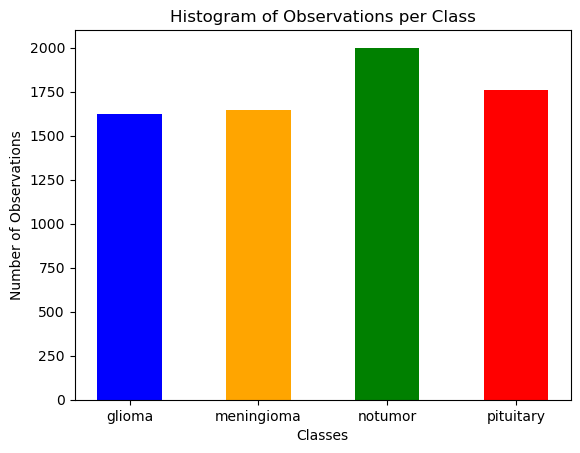

In [6]:
all_data = np.concatenate((train_data, test_data), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)
class_names = np.array(categories)
class_counts = np.sum(all_labels, axis=0)
colors = ['blue', 'orange', 'green', 'red']  
bar_width = 0.5  
plt.bar(class_names, class_counts, color=colors, width=bar_width)
plt.xlabel('Classes')
plt.ylabel('Number of Observations')
plt.title('Histogram of Observations per Class')
plt.show()

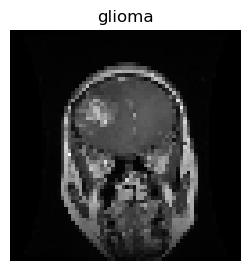

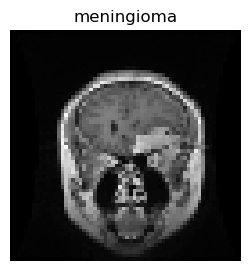

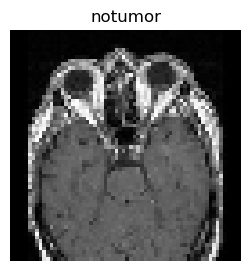

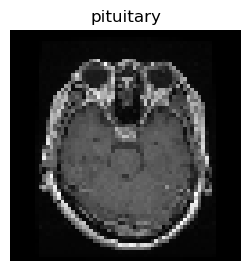

In [7]:
def display_images_per_category(data, labels, categories):
    for category in categories:
        index = np.argmax(labels[:, categories.index(category)])
        
        plt.figure(figsize=(3, 3))
        plt.imshow(data[index], cmap='gray')
        plt.title(category)
        plt.axis('off')
        plt.show()

display_images_per_category(all_data, all_labels, categories)

In [11]:
np.random.seed(42)
tf.random.set_seed(42)
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Choice('conv1_filters', values=[32, 64]), 
                            kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
                            activation='relu',
                            input_shape=(img_size, img_size, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Choice('conv2_filters', values=[32, 64,128]), 
                            kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
                            activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Choice('dense_units',values=[64,128]),
                           activation='relu'))
    model.add(layers.Dropout(hp.Choice('dense_dropout', values=[0.3,0.5] )))
    model.add(layers.Dense(len(categories), activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [44]:
directory_to_delete = 'Tuner direct'
shutil.rmtree(directory_to_delete)

In [14]:
X = train_data
y = train_labels

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='Tuner_direct',
                     project_name='Brain_tumor_direct')

n_folds = 5  

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
tensorboard_callback = TensorBoard(log_dir='logsdir', write_graph=True, write_images=True)


for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    train_data_fold, train_labels_fold = X[train_index], y[train_index]
    val_data_fold, val_labels_fold = X[val_index], y[val_index]
    tuner.search(train_data_fold, train_labels_fold, epochs=10, validation_data=(val_data_fold, val_labels_fold), batch_size=64)
!tensorboard --logdir=logsdir

Trial 30 Complete [00h 02m 23s]
val_accuracy: 0.9247593879699707

Best val_accuracy So Far: 0.9440069794654846
Total elapsed time: 01h 09m 04s
^C


In [15]:
best_trial = tuner.oracle.get_best_trials(1)[0]
best_trial
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp)
best_hyperparameters = best_trial.hyperparameters.values
print(best_hyperparameters)

{'conv1_filters': 32, 'conv1_kernel_size': 5, 'conv2_filters': 128, 'conv2_kernel_size': 5, 'dense_units': 128, 'dense_dropout': 0.3, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


Epoch 1/10
179/179 [==============================] - 57s 311ms/step - loss: 0.6974 - accuracy: 0.7155
Epoch 2/10
179/179 [==============================] - 56s 313ms/step - loss: 0.3948 - accuracy: 0.8514
Epoch 3/10
179/179 [==============================] - 58s 324ms/step - loss: 0.2775 - accuracy: 0.8969
Epoch 4/10
179/179 [==============================] - 59s 328ms/step - loss: 0.2108 - accuracy: 0.9217
Epoch 5/10
179/179 [==============================] - 56s 315ms/step - loss: 0.1394 - accuracy: 0.9520
Epoch 6/10
179/179 [==============================] - 57s 316ms/step - loss: 0.1012 - accuracy: 0.9664
Epoch 7/10
179/179 [==============================] - 57s 319ms/step - loss: 0.0801 - accuracy: 0.9716
Epoch 8/10
179/179 [==============================] - 60s 334ms/step - loss: 0.0506 - accuracy: 0.9835
Epoch 9/10
179/179 [==============================] - 55s 308ms/step - loss: 0.0372 - accuracy: 0.9872
Epoch 10/10
41/41 [==============================] - 4s 98ms/step


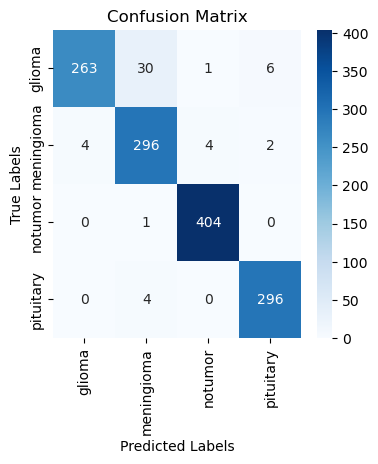

In [16]:
np.random.seed(42)
tf.random.set_seed(42)
model = tuner.hypermodel.build(best_hp)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_data, train_labels, epochs=10)
labels_pred = model.predict(test_data)
predicted_classes = np.argmax(labels_pred, axis=1)
true_classes = np.argmax(test_labels, axis=1)

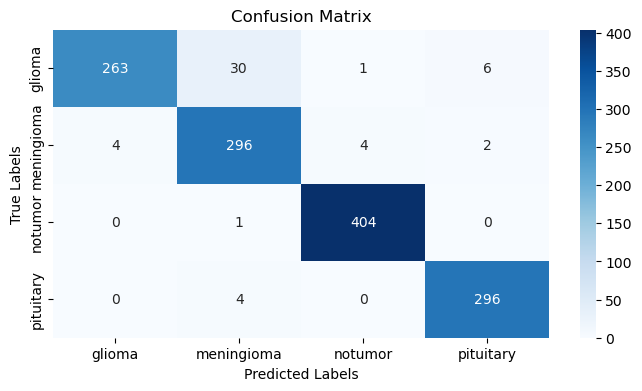

In [17]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(2*len(categories), len(categories)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [18]:
test_labels_mc = np.argmax(test_labels, axis=1)
print(classification_report(test_labels_mc, labels_pred.argmax(axis=1), target_names=categories))
report_dict = classification_report(test_labels_mc, labels_pred.argmax(axis=1), target_names=categories, output_dict=True)
report_df = pd.DataFrame(report_dict)
print(report_df)

              precision    recall  f1-score   support

      glioma       0.99      0.88      0.93       300
  meningioma       0.89      0.97      0.93       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311

               glioma  meningioma     notumor   pituitary  accuracy  \
precision    0.985019    0.894260    0.987775    0.973684  0.960336   
recall       0.876667    0.967320    0.997531    0.986667  0.960336   
f1-score     0.927690    0.929356    0.992629    0.980132  0.960336   
support    300.000000  306.000000  405.000000  300.000000  0.960336   

             macro avg  weighted avg  
precision     0.960184      0.962093  
recall        0.957046      0.960336  
f1-score      0.957452      0.960141  
support    1311.000000   1311.000000  


In [19]:
plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       102528    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 21632)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [3]:
def GrayscaleVGG16(input_shape=(64, 64, 1), num_classes=4):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    for layer in base_model.layers:
        layer.trainable = False

    
    input_tensor = Input(shape=input_shape)
    x = Conv2D(3, (3, 3), padding='same', activation='relu')(input_tensor)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model_p = Model(inputs=input_tensor, outputs=output_tensor)

    return model_p

model_p = GrayscaleVGG16(input_shape=(64, 64, 1), num_classes=4)

model_p.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_p.fit(train_data, train_labels, epochs=10, batch_size=64)





Epoch 1/10


90/90 [==============================] - 516s 6s/step - loss: 0.8031 - accuracy: 0.6900
Epoch 2/10
90/90 [==============================] - 486s 5s/step - loss: 0.5103 - accuracy: 0.8174
Epoch 3/10
90/90 [==============================] - 467s 5s/step - loss: 0.4077 - accuracy: 0.8512
Epoch 4/10
90/90 [==============================] - 475s 5s/step - loss: 0.3658 - accuracy: 0.8675
Epoch 5/10
90/90 [==============================] - 490s 5s/step - loss: 0.3307 - accuracy: 0.8776
Epoch 6/10
90/90 [==============================] - 477s 5s/step - loss: 0.2984 - accuracy: 0.8925
Epoch 7/10
90/90 [==============================] - 486s 5s/step - loss: 0.2775 - accuracy: 0.8985
Epoch 8/10
90/90 [==============================] - 466s 5s/step - loss: 0.2609 - accuracy: 0.9009
Epoch 9/10
90/90 [==============================] - 458s 5s/step - loss: 0.2467 - accuracy: 0.9105
Epoch 10/10
41/41 [==============================] - 55s 1s/step


NameError: name 'tnp' is not defined

In [4]:
predictions_p = model_p.predict(test_data)

predictions_p = np.argmax(predictions_p, axis=1)

labels_test = np.argmax(test_labels, axis=1)

accuracy_p = accuracy_score(labels_test, predictions_p)

print('Accuracy:', accuracy_p)


41/41 [==============================] - 50s 1s/step
Accuracy: 0.8581235697940504


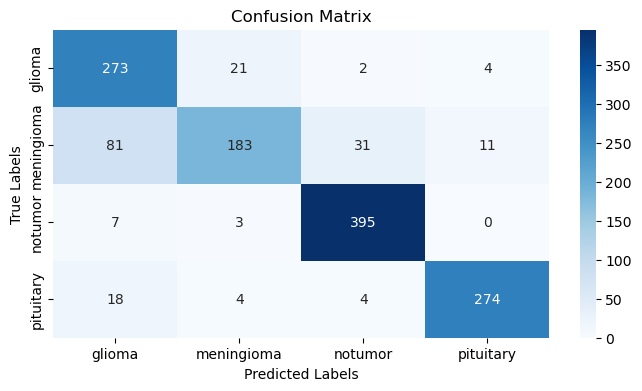

In [5]:
cm_p = confusion_matrix(labels_test, predictions_p)
plt.figure(figsize=(2*len(categories), len(categories)))
sns.heatmap(cm_p, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [6]:
print(classification_report(labels_test, predictions_p, target_names=categories))

              precision    recall  f1-score   support

      glioma       0.72      0.91      0.80       300
  meningioma       0.87      0.60      0.71       306
     notumor       0.91      0.98      0.94       405
   pituitary       0.95      0.91      0.93       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.87      0.86      0.85      1311



In [7]:
model_p.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         30        
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                             